In [1]:
### Perform NEP analysis with squidpy
import anndata
import pandas as pd
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import time, os, sys
import glob
import warnings
import numpy as np
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import myocardial infarction dataset
path_to_csv = './../../../MI_heart_paper/data/cell_table_final.csv'
obs = pd.read_csv(path_to_csv)

In [3]:
#filter out exclude cell types
ignore_cell_types = ['exclude']
obs = obs[~obs['final_cell_type'].isin(ignore_cell_types)]

# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Ensure obs has a string-based index
obs.index = obs.index.astype(str)  

# Load dataframe into anndata object
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs
adata

AnnData object with n_obs × n_vars = 563180 × 2
    obs: 'fov', 'label', 'cell_size', 'X_centroid', 'Y_centroid', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster', 'timepoint', 'region', 'region_name', 'refined_cell_type', 'final_cell_type', 'endocardial_annotation', 'exclude_annotation', 'artefact', 'distance_from_lumen', 'lumen_bin', 'size_filter', 'D', 'E'

In [5]:
# get spatial coordinates to be in obsm
adata.obsm['spatial'] = obs[['X_centroid', 'Y_centroid']].values
# make "refined_cell_types" a categorical variable
adata.obs['final_cell_type'] = pd.Categorical(adata.obs['final_cell_type'])

In [6]:
# Run NEP per 'fov'
fov_list = adata.obs['fov'].unique()

# Dictionary to store fov-specific AnnData objects
fov_adata_dict = {}

# Loop over each fov
for fov in fov_list:
    # Create a subset of adata for the specific FOV
    fov_adata = adata[adata.obs['fov'] == fov].copy()

    # Perform spatial neighbors analysis on the subset
    sq.gr.spatial_neighbors(fov_adata, coord_type = 'generic', delaunay=True)
    sq.gr.nhood_enrichment(fov_adata, cluster_key="final_cell_type", n_perms=300, seed=fov_list.tolist().index(fov), show_progress_bar=False)
    # Store the result in the dictionary
    fov_adata_dict[fov] = fov_adata


/Users/chiaraschiller/miniconda3/envs/squidpy_MI/lib/python3.10/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


## ZSCORE

In [15]:
flattened_dfs = []

# Loop through each fov in the dictionary
for fov, fov_adata in fov_adata_dict.items():
    # Extract the zscore matrix
    zscore_matrix = fov_adata.uns['final_cell_type_nhood_enrichment']['zscore']
    cell_types = fov_adata.obs['final_cell_type'].cat.categories
    assert len(cell_types) == zscore_matrix.shape[0] == zscore_matrix.shape[1], "Dimension mismatch!"
    zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)
    flattened_df = zscore_df.stack().reset_index()
    flattened_df.columns = ['rowname', 'colname', 'zscore']
    flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']
    flattened_df['fov'] = fov

    # Retain only the combined, zscore, and fov columns
    flattened_df = flattened_df[['fov', 'combined', 'zscore']]
    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames into one big DataFrame
big_dataframe = pd.concat(flattened_dfs, ignore_index=True)

final_dataframe = big_dataframe.pivot(index='fov', columns='combined', values='zscore')
final_dataframe.reset_index('fov', inplace=True)

# store dataframe
final_dataframe.to_csv('./../../../SCNA_thesis/github/Comparison/20250218_results_MI/squidpy_zscore_delaunay.csv', index=True)  # Set index=False to avoid saving the index as a column
final_dataframe

combined         fov  Cardiomyocytes Ankrd1+_Cardiomyocytes  \
0             24h_83                            -195.917285   
1             24h_86                            -199.137661   
2             48h_76                            -127.249593   
3             48h_79                            -157.506721   
4              4h_96                            -158.476835   
5              4h_97                            -103.481794   
6         Control_12                             -21.573701   
7         Control_13                              -5.614258   
8         Control_14                              -6.609134   

combined  Cardiomyocytes Ankrd1+_Cardiomyocytes Ankrd1+  \
0                                            243.346239   
1                                            263.553997   
2                                            151.659020   
3                                            216.267062   
4                                            179.053254   
5              

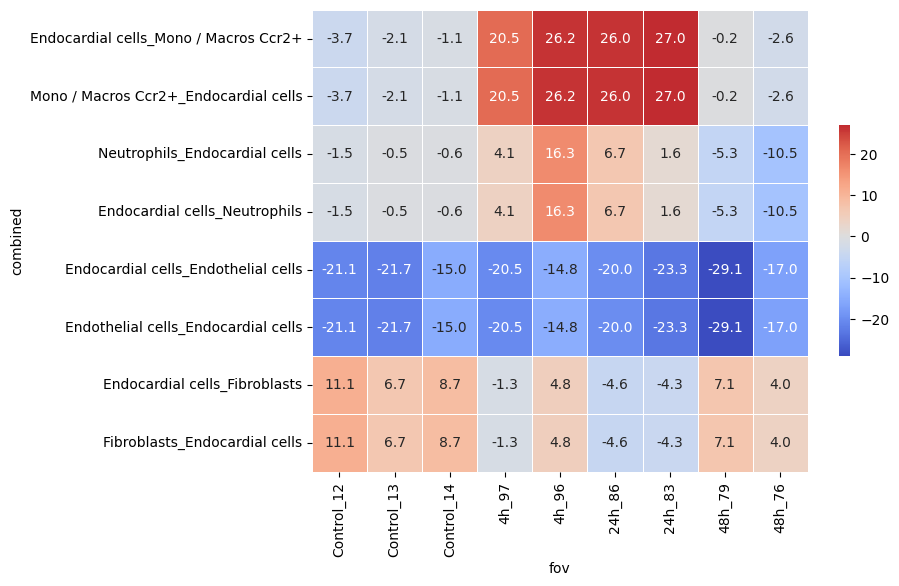

In [16]:
# Plot interaction to check
column_order = [
    'Control_12', 'Control_13', 'Control_14', '4h_97', '4h_96', '24h_86',
    '24h_83', '48h_79', '48h_76'
]

desired_rows = [
    'Endocardial cells_Mono / Macros Ccr2+',
    'Mono / Macros Ccr2+_Endocardial cells', 'Neutrophils_Endocardial cells', 'Endocardial cells_Neutrophils',
    'Endocardial cells_Endothelial cells', 'Endothelial cells_Endocardial cells',
    'Endocardial cells_Fibroblasts', 'Fibroblasts_Endocardial cells',
]  

# Ensure the DataFrame is transposed
transposed_df = final_dataframe.set_index('fov').T
transposed_df = transposed_df[column_order]
# Filter the DataFrame for the NEP pairs of interest
transposed_df = transposed_df.loc[desired_rows]

# Create a plot
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(transposed_df,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f",
            linewidths=.5,#annot=True,
            cbar_kws={"shrink": .5})

plt.show()

# COUNTS

In [9]:
#now check the extracted count

# Initialize a list to hold each flattened DataFrame
flattened_dfs = []

# Loop through each fov in the dictionary
for fov, fov_adata in fov_adata_dict.items():
    # Extract the count matrix
    zscore_matrix = fov_adata.uns['final_cell_type_nhood_enrichment']['count']
    cell_types = fov_adata.obs['final_cell_type'].cat.categories
    assert len(cell_types) == zscore_matrix.shape[0] == zscore_matrix.shape[1], "Dimension mismatch!"
    zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)
    flattened_df = zscore_df.stack().reset_index()
    flattened_df.columns = ['rowname', 'colname', 'count']
    flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']
    flattened_df['fov'] = fov
    
    # Retain only the combined, zscore, and fov columns
    flattened_df = flattened_df[['fov', 'combined', 'count']]
    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames into one big DataFrame
big_dataframe = pd.concat(flattened_dfs, ignore_index=True)
final_dataframe = big_dataframe.pivot(index='fov', columns='combined', values='count')
final_dataframe.reset_index('fov',inplace=True)

# store dataframe
final_dataframe.to_csv('./../../../SCNA_thesis/github/Comparison/20250218_results_MI/squidpy_zscore_delaunay.csv', index=True)  # Set index=False to avoid saving the index as a column
final_dataframe

combined         fov  Cardiomyocytes Ankrd1+_Cardiomyocytes  \
0             24h_83                                   5088   
1             24h_86                                  11411   
2             48h_76                                   1865   
3             48h_79                                   2202   
4              4h_96                                  21167   
5              4h_97                                  13542   
6         Control_12                                   3237   
7         Control_13                                    200   
8         Control_14                                    173   

combined  Cardiomyocytes Ankrd1+_Cardiomyocytes Ankrd1+  \
0                                                 61474   
1                                                 42620   
2                                                 27150   
3                                                 34770   
4                                                 53512   
5              

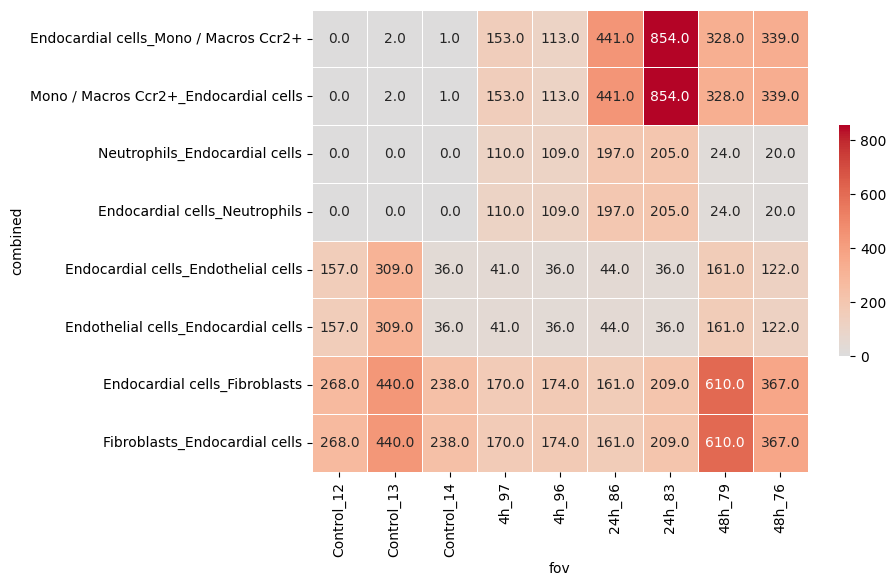

In [11]:
# Ensure the DataFrame is transposed
transposed_df = final_dataframe.set_index('fov').T
transposed_df = transposed_df[column_order]
# Filter the DataFrame for the NEP pairs of interest
transposed_df = transposed_df.loc[desired_rows]

# Create a plot
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(transposed_df,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f",
            linewidths=.5,#annot=True,
            cbar_kws={"shrink": .5})

plt.show()